In [32]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from google.colab import drive
from keras.callbacks import ModelCheckpoint, Callback
import numpy as np
from sklearn.metrics import f1_score

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super(F1ScoreCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y_val, axis=1)
        f1 = f1_score(y_true, y_pred, average='macro')
        print("F1 score: {:.4f}".format(f1))
        self.f1_scores.append(f1)

checkpoint_path = "/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_freq='epoch')

data = pd.read_csv('/bbc-text.csv')

labels = pd.Categorical(data['category']).codes

one_hot_labels = to_categorical(labels)

data = pd.concat([data.drop('category', axis=1), pd.DataFrame(one_hot_labels)], axis=1)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'].astype(str))
sequences = tokenizer.texts_to_sequences(data['text'].astype(str))

vocab_size = len(tokenizer.word_index) + 1

max_len = 2457
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

f1score_callback = F1ScoreCallback(X_test, y_test)
import seaborn as sns
from sklearn.metrics import confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

Epoch 1/10
14/14 [==============================] - 11s 804ms/step
F1 score: 0.1499
13/13 [==============================] - 66s 5s/step - loss: 1.5936 - accuracy: 0.2628 - val_loss: 1.5567 - val_accuracy: 0.3708
Epoch 2/10
14/14 [==============================] - 13s 918ms/step
F1 score: 0.2432
13/13 [==============================] - 72s 6s/step - loss: 1.5629 - accuracy: 0.3396 - val_loss: 1.5131 - val_accuracy: 0.4326
Epoch 3/10
14/14 [==============================] - 13s 919ms/step
F1 score: 0.2785
13/13 [==============================] - 77s 6s/step - loss: 1.5333 - accuracy: 0.3951 - val_loss: 1.4816 - val_accuracy: 0.4944
Epoch 4/10
14/14 [==============================] - 13s 921ms/step
F1 score: 0.3049
13/13 [==============================] - 78s 6s/step - loss: 1.5052 - accuracy: 0.4345 - val_loss: 1.4637 - val_accuracy: 0.5112
Epoch 5/10
14/14 [==============================] - 13s 921ms/step
F1 score: 0.2816
13/13 [==============================] - 72s 6s/step - loss: 1.4

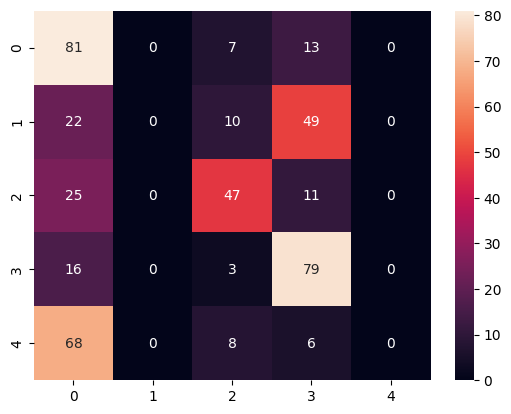

In [22]:
from tensorflow import keras
from keras.utils import custom_object_scope

with custom_object_scope({'focal_loss_fixed': focal_loss()}):
  loaded_model = keras.models.load_model('/model.hdf5')

  for layer in loaded_model.layers[:-2]:
      layer.trainable = False


  from tensorflow.keras import layers

  d = layers.Dense(20, activation='softmax')(loaded_model.layers[-2].output)

  output_layer = layers.Dense(5, activation='softmax')(d)

  model = keras.models.Model(inputs=loaded_model.inputs, outputs=output_layer)

  model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

  model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, callbacks=[f1score_callback])

  loss, accuracy = model.evaluate(X_test, y_test)
  print('Test loss:', loss)
  print('Test accuracy:', accuracy)

  y_pred = model.predict(X_test)

  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_test, axis=1)

  cm = confusion_matrix(y_true_labels, y_pred_labels)
  df=pd.DataFrame(cm,index=[i for i in range(5)],columns=[i for i in range(5)])

  sns.heatmap(df,annot=True)

In [ ]:
from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, concatenate, Input
from tensorflow.keras.models import Model

input = Input(shape=(max_len,)) 
embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(input) 

c1 = Conv1D(100,3,padding='same',activation='relu',strides=1)(embedding)
c2 = Conv1D(100,5,padding='same',activation='relu',strides=1)(embedding)
c3 = Conv1D(100,10,padding='same',activation='relu',strides=1)(embedding)

c = concatenate([c1, c2, c3])

p = GlobalMaxPooling1D()(c)

d = Dense(units=128, activation='relu')(p)

output = Dense(units=y_train.shape[1], activation='softmax')(d)

model = Model(inputs=input, outputs=output)

model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=10.), metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, callbacks=[f1score_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
df=pd.DataFrame(cm,index=[i for i in range(5)],columns=[i for i in range(5)])

sns.heatmap(df,annot=True)

In [ ]:
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
import joblib

svm_model_loaded = joblib.load('/content/drive/MyDrive/svm_model.pkl')

data = pd.read_csv('/bbc-text.csv')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['category'], test_size=0.1, random_state=42)

vectorizer = TfidfVectorizer(max_features=160155)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

X_train_svm = svm_model_loaded.decision_function(X_train)
X_test_svm = svm_model_loaded.decision_function(X_test)

model = Sequential()
model.add(Dense(64, input_dim=X_train_svm.shape[1], activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(X_train_svm, y_train, epochs=10, batch_size=128, validation_data=(X_test_svm, y_test), callbacks=[f1score_callback])

score = model.evaluate(X_test_svm, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

